In [23]:
"""Randomize player A and B"""

import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/atp_matches_2000-2024.csv')
df_training = df.copy()

# Identify rows where we should flip players (randomly select 50% of rows)
np.random.seed(42) 
flip_mask = np.random.rand(len(df_training)) < 0.5

# Flip the selected rows
df_training.loc[flip_mask, ['player_A_name', 'player_B_name']] = df_training.loc[flip_mask, ['player_B_name', 'player_A_name']].values
df_training.loc[flip_mask, ['player_A_rank', 'player_B_rank']] = df_training.loc[flip_mask, ['player_B_rank', 'player_A_rank']].values
df_training.loc[flip_mask, ['player_A_rank_points', 'player_B_rank_points']] = df_training.loc[flip_mask, ['player_B_rank_points', 'player_A_rank_points']].values

# Flip all ELO columns
elo_cols = [col for col in df_training.columns if col.startswith('elo_A_') or col.startswith('elo_B_')]
for elo_col in elo_cols:
    if elo_col.startswith('elo_A_'):
        partner_col = elo_col.replace('elo_A_', 'elo_B_')
        if partner_col in df_training.columns:
            df_training.loc[flip_mask, [elo_col, partner_col]] = df_training.loc[flip_mask, [partner_col, elo_col]].values

df_training['player_A_win'] = (df_training['winner_name'] == df_training['player_A_name']).astype(int)
df_training = df_training.drop(columns=['winner_name', 'score'])

# Save the new training dataset
df_training.to_csv('../data/processed/atp_matches_training.csv', index=False)
df_training.head()

,date,tournament_name,surface,round,best_of,player_A_name,player_B_name,player_A_rank,player_B_rank,player_A_rank_points,...,elo_B_post_Hard,elo_A_pre_Clay,elo_B_pre_Clay,elo_A_post_Clay,elo_B_post_Clay,elo_A_pre_Grass,elo_B_pre_Grass,elo_A_post_Grass,elo_B_post_Grass,player_A_win
0,2000-01-03,Adelaide,Hard,SF,3,Nicolas Escude,Lleyton Hewitt,37.0,25.0,995.0,...,1512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2000-01-03,Chennai,Hard,R32,3,Lorenzo Manta,Tomas Zib,115.0,111.0,399.0,...,1488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2000-01-03,Chennai,Hard,R32,3,Leander Paes,Julien Boutter,142.0,133.0,326.0,...,1488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2000-01-03,Chennai,Hard,R32,3,Davide Sanguinetti,Adrian Voinea,120.0,100.0,388.0,...,1488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2000-01-03,Chennai,Hard,R32,3,Alex Lopez Moron,Andreas Vinciguerra,116.0,98.0,397.0,...,1512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [24]:
# Reload the training data to get the flipped ELO columns
df_training = pd.read_csv('../data/processed/atp_matches_training.csv')

# Create elo_diff: difference between player A and player B pre-match ELO
df_training['elo_diff'] = df_training['elo_A_pre'] - df_training['elo_B_pre']

# Create surf_elo_diff based on surface-specific ELO
def get_surface_elo_diff(row):
    surface = row['surface']
    
    # Get the pre ELO columns for this surface
    elo_a_col = f'elo_A_pre_{surface}'
    elo_b_col = f'elo_B_pre_{surface}'
    
    # Check if columns exist and have values
    if elo_a_col in df_training.columns and elo_b_col in df_training.columns:
        a_val = row[elo_a_col]
        b_val = row[elo_b_col]
        
        # If either is NaN, return NaN
        if pd.isna(a_val) or pd.isna(b_val):
            return None
        return a_val - b_val
    return None

df_training['surf_elo_diff'] = df_training.apply(get_surface_elo_diff, axis=1)

# Drop all the individual ELO columns
elo_cols_to_drop = [col for col in df_training.columns if col.startswith('elo_') and col != 'elo_diff']
df_training = df_training.drop(columns=elo_cols_to_drop)

# Save the modified training dataset
df_training.to_csv('../data/processed/atp_matches_training.csv', index=False)
df_training.head()

,date,tournament_name,surface,round,best_of,player_A_name,player_B_name,player_A_rank,player_B_rank,player_A_rank_points,player_B_rank_points,player_A_win,elo_diff,surf_elo_diff
0,2000-01-03,Adelaide,Hard,SF,3,Nicolas Escude,Lleyton Hewitt,37.0,25.0,995.0,1429.0,0,0.0,0.0
1,2000-01-03,Chennai,Hard,R32,3,Lorenzo Manta,Tomas Zib,115.0,111.0,399.0,408.0,1,0.0,0.0
2,2000-01-03,Chennai,Hard,R32,3,Leander Paes,Julien Boutter,142.0,133.0,326.0,342.0,1,0.0,0.0
3,2000-01-03,Chennai,Hard,R32,3,Davide Sanguinetti,Adrian Voinea,120.0,100.0,388.0,478.0,1,0.0,0.0
4,2000-01-03,Chennai,Hard,R32,3,Alex Lopez Moron,Andreas Vinciguerra,116.0,98.0,397.0,486.0,0,0.0,0.0


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Load the training data
df = pd.read_csv('../data/processed/atp_matches_training.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year for easier splitting
df['year'] = df['date'].dt.year

# Define features (exclude non-numeric and target columns)
feature_cols = ['player_A_rank', 'player_B_rank', 'player_A_rank_points', 'player_B_rank_points', 'elo_diff', 'surf_elo_diff']

# Split data by year
train_data = df[df['year'] <= 2022]
val_data = df[df['year'] == 2023]
test_data = df[df['year'] == 2024]

print(f"Train: {len(train_data)} samples")
print(f"Val: {len(val_data)} samples")
print(f"Test: {len(test_data)} samples")

# Prepare features and target
X_train = train_data[feature_cols].fillna(train_data[feature_cols].mean())
y_train = train_data['player_A_win']

X_val = val_data[feature_cols].fillna(train_data[feature_cols].mean())
y_val = val_data['player_A_win']

X_test = test_data[feature_cols].fillna(train_data[feature_cols].mean())
y_test = test_data['player_A_win']

# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate on all sets
for name, X, y in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{name} Results:")
    print(f"  Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"  Precision: {precision_score(y, y_pred):.4f}")
    print(f"  Recall: {recall_score(y, y_pred):.4f}")
    print(f"  F1: {f1_score(y, y_pred):.4f}")
    print(f"  ROC-AUC: {roc_auc_score(y, y_pred_proba):.4f}")

# Print feature coefficients
print(f"\nFeature Coefficients:")
for feat, coef in zip(feature_cols, model.coef_[0]):
    print(f"  {feat}: {coef:.4f}")

Train: 68844 samples
Val: 2986 samples
Test: 3076 samples

Train Results:
  Accuracy: 0.6672
  Precision: 0.6669
  Recall: 0.6685
  F1: 0.6677
  ROC-AUC: 0.7313

Val Results:
  Accuracy: 0.6417
  Precision: 0.6421
  Recall: 0.6378
  F1: 0.6400
  ROC-AUC: 0.7032

Test Results:
  Accuracy: 0.6466
  Precision: 0.6386
  Recall: 0.6550
  F1: 0.6467
  ROC-AUC: 0.7084

Feature Coefficients:
  player_A_rank: -0.0011
  player_B_rank: 0.0011
  player_A_rank_points: -0.0000
  player_B_rank_points: 0.0000
  elo_diff: 0.0032
  surf_elo_diff: 0.0024


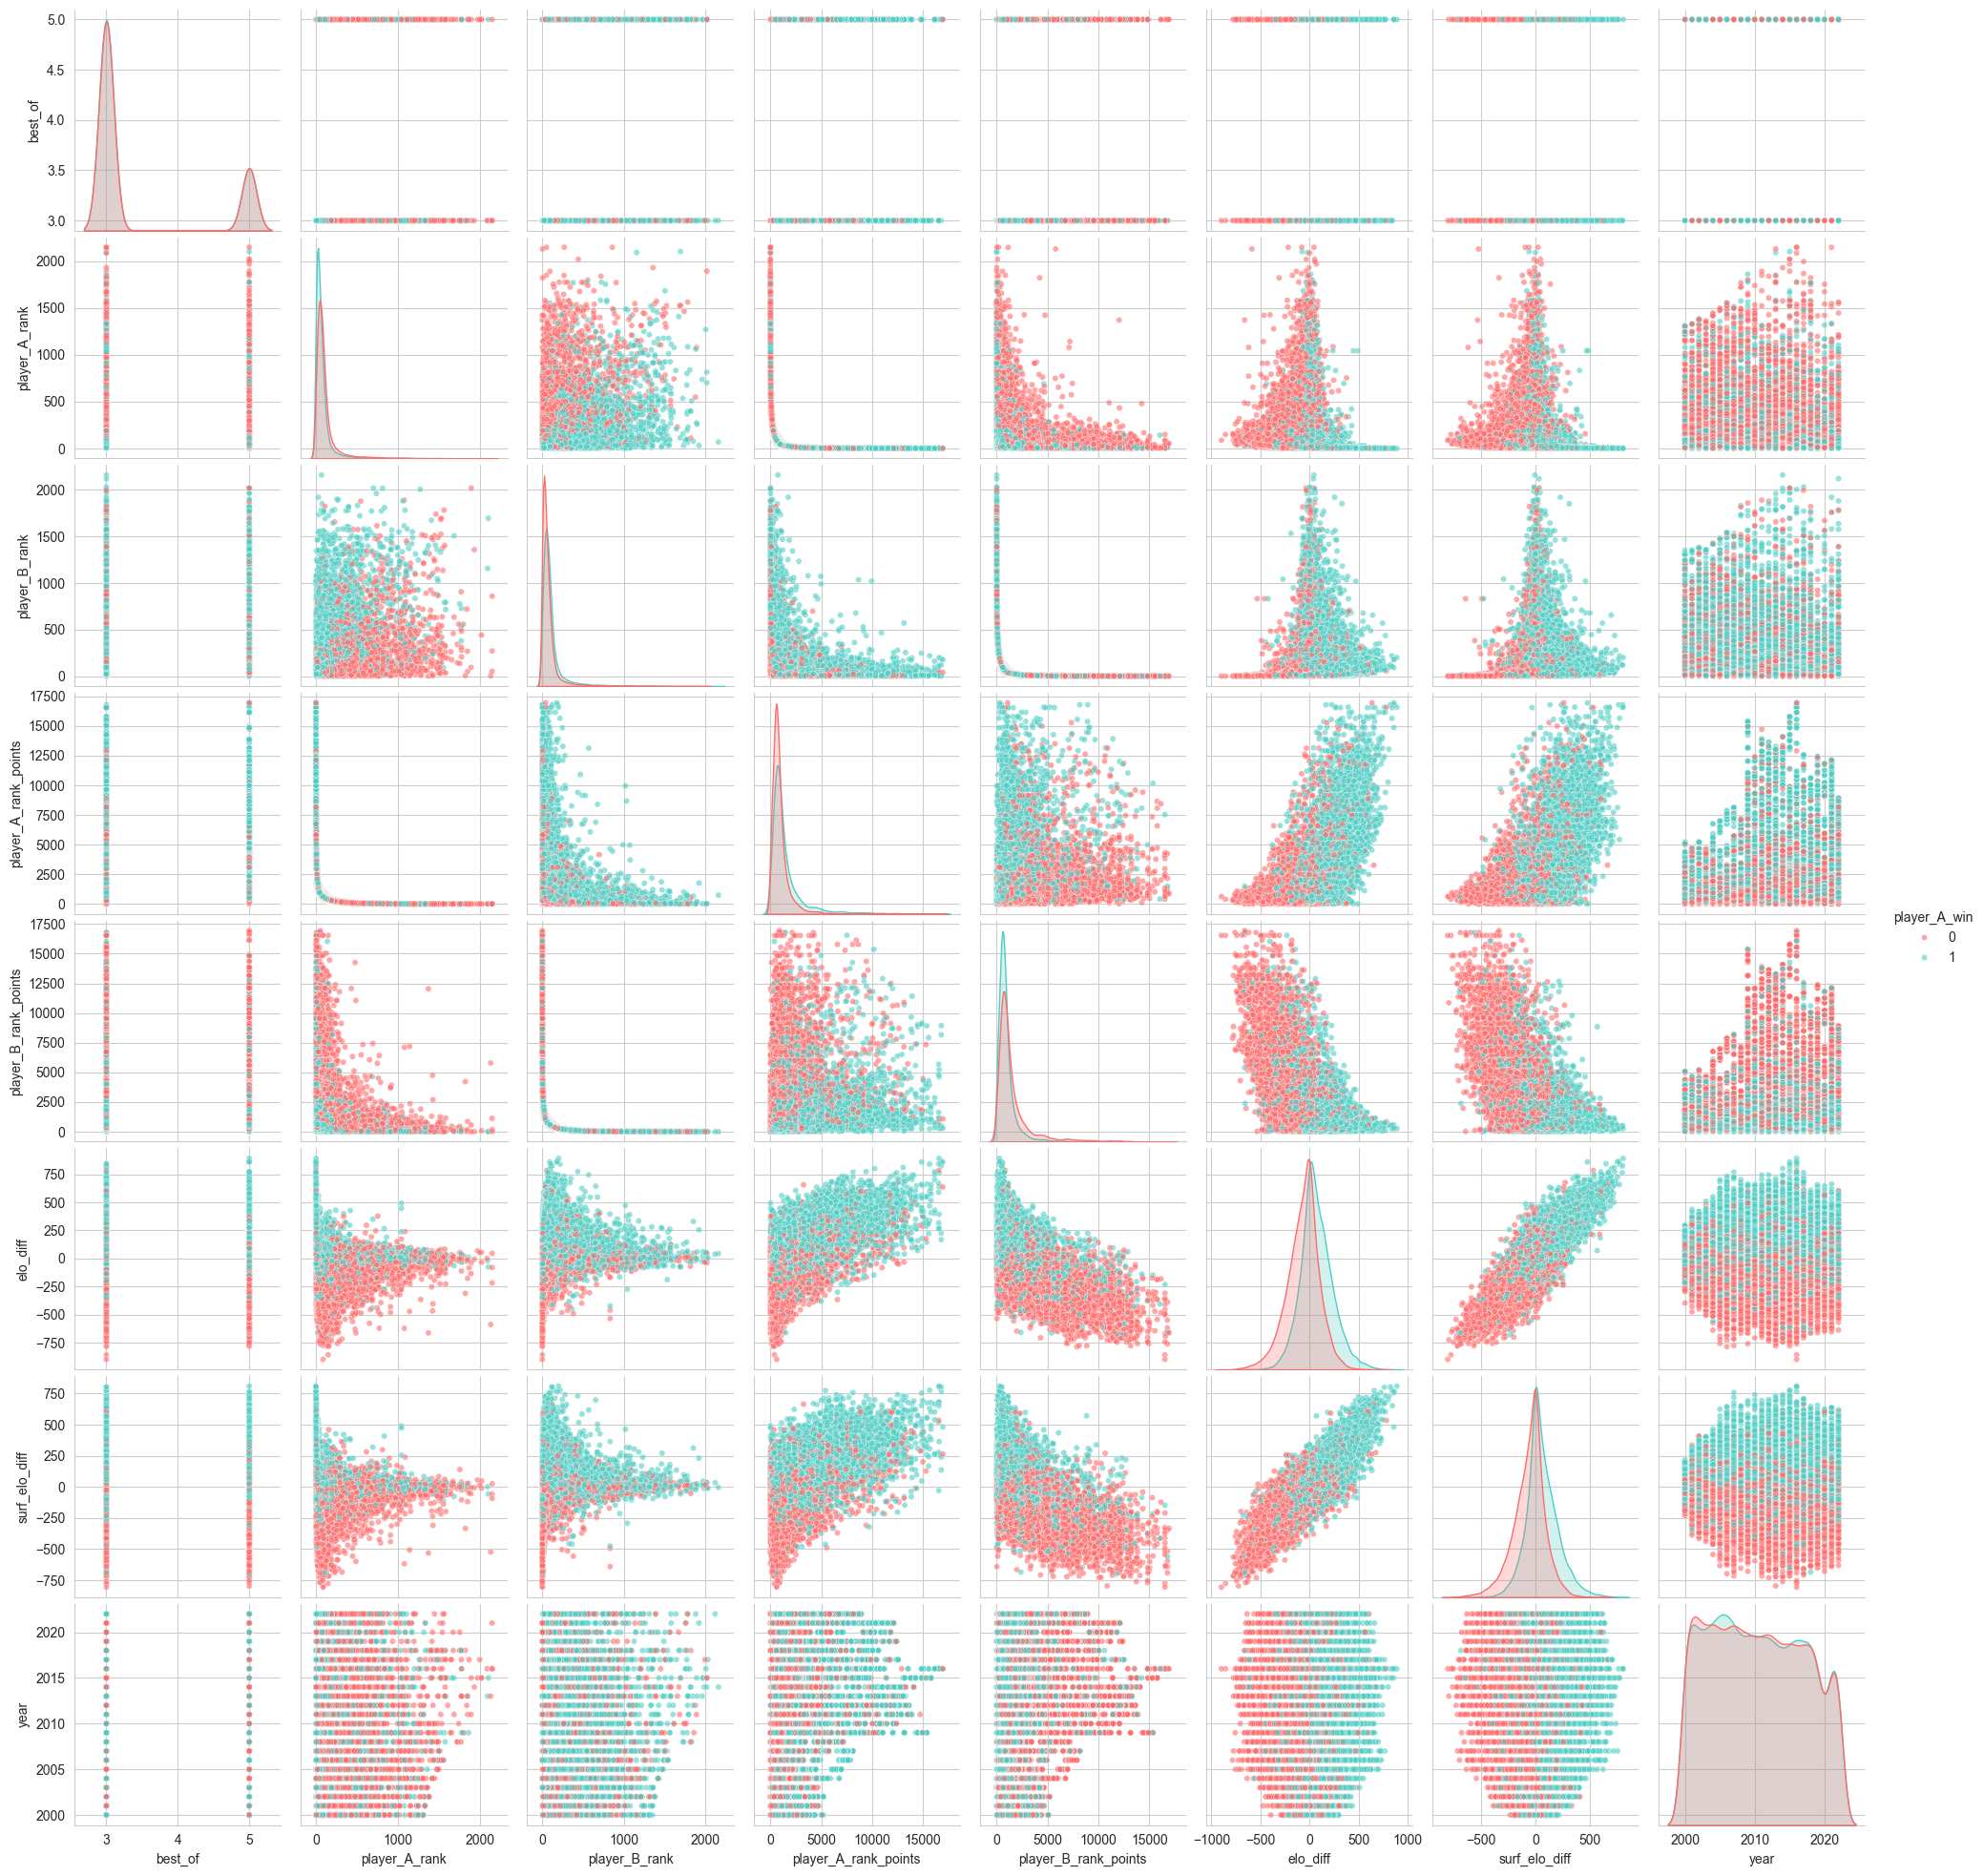

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reload data for plotting
df_plot = pd.read_csv('../data/processed/atp_matches_training.csv')
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['year'] = df_plot['date'].dt.year

# Use training data only
df_plot = df_plot[df_plot['year'] <= 2022]

# Select all numeric columns as features
numeric_cols = df_plot.select_dtypes(include=['number']).columns.tolist()
df_pairplot = df_plot.copy()

# Create pairplot
sns.pairplot(df_pairplot, hue='player_A_win', palette=['#FF6B6B', '#4ECDC4'], 
             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
plt.show()